In [101]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, as_float_array
from sklearn.datasets import make_regression

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

from scipy.stats import entropy
from copy import deepcopy as copy

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# https://www.theanalysisfactor.com/continuous-and-categorical-variables-the-trouble-with-median-splits/

In [200]:
class MaxentropyDichtomizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, verbose=False):
        self.n_splits = n_splits
        
        self.n_samples = None
        self.n_features = None
        self._splits = None
        self._splits_indices = None
    
    def _check_X(self, X, n_features=None):
        _X = None
        if not hasattr(X, 'dtype'):
            _X = check_array(as_float_array(X))
        _X = check_array(X)
        
        if self.n_features:
            if _X.shape[1] != self.n_features:
                raise Exception('X has {} columns while {} are expected'.format(_X.shape[1], self.n_features))
        return _X
    
    def _get_maxentropy_split(self, X):
        block_size = X.shape[0]
        ix_max_entropy = -1
        max_entropy = -1
        max_probas = None
        for i in range(1, block_size - 1):
            a = np.sum(X < X[i])
            b = np.sum(X >= X[i])

            p = np.array([a / block_size, b / block_size])
            e = -np.sum(np.log(p + 1) * p)

            if max_entropy < e:
                max_probas = p
                max_entropy = e
                ix_max_entropy = i
        
        if max_probas is None or 0 in max_probas:
            return 0, -1

        return max_entropy, ix_max_entropy

    def _dichtomize(self, X):
        _iters = np.log2(self.n_splits)
        if _iters - int(_iters) != 0:
            raise Exception('number of bins should be of a power of 2')
        
        # make first maxentropy split
        _, initial_bin = self._get_maxentropy_split(X)
        splits_current_feature = [(0, initial_bin), (initial_bin, self.n_samples - 1)]
        for i in range(int(_iters) - 1):
            # an empty list for splits in current iteration
            _splits = list()
            for j in splits_current_feature:
                entropy, index = self._get_maxentropy_split(X[j[0]: j[1]])
                if entropy == 0:
                    _splits += [(j[0], j[1])]
                else:
                    _splits += [(j[0], j[0] + index), (j[0] + index, j[1])]

            splits_current_feature = _splits
            
        return splits_current_feature
    
    def _convert(self, X, ix):
        result = list()
        for x in X.flatten():
            result.append(np.argwhere([k[0] <= x and x < k[1] for k in self._splits[ix]]))
        return np.array(result).reshape(-1, 1) 
    
    def fit(self, X):
        X = self._check_X(X)
        self.n_samples, self.n_features = X.shape
        
        self._splits = list()
        self._splits_indices = list()
        
        for ix in range(self.n_features):
            x = np.sort(X[:, ix].flatten())
            _indices = self._dichtomize(x.flatten())
            
            self._splits_indices.append(_indices)
            self._splits.append([[x[i[0]], x[i[1]]] for i in _indices])
            
            self._splits[-1][0][0] = -np.inf
            self._splits[-1][-1][1] = np.inf
            
            self._splits = np.array(self._splits)
            
        return self
    
    def transform(self, X):
        _, n_features = X.shape
        X = self._check_X(X, n_features)
        
        X_categorical = list()
        for ix in range(n_features):
            X_categorical.append(self._convert(X, ix))
            
        return np.hstack(X_categorical)

In [218]:
def synchronize_counts(_from: dict, _to: dict):
    subset = np.setdiff1d(list(_from.keys()), list(_to.keys()))
    for i in subset:
        _to[i] = 0

In [217]:
def cross_entropy(p, q):
    p = np.array(p)
    q = np.array(q)
    q[q == 0] = 1e-8
    return -np.sum(p * np.log(q))

# Эксперимент по бинаризации данных из разных распределений

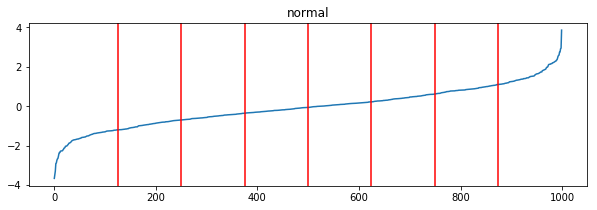

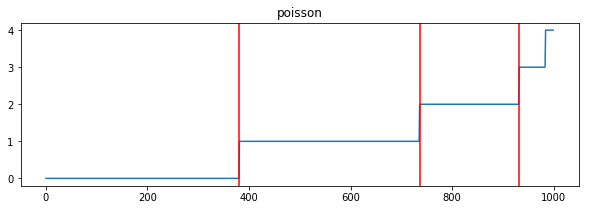

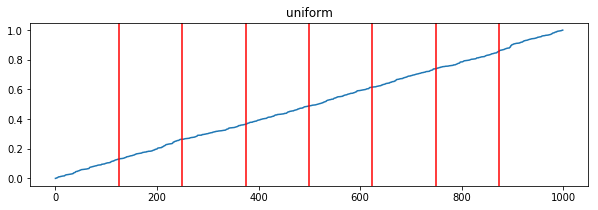

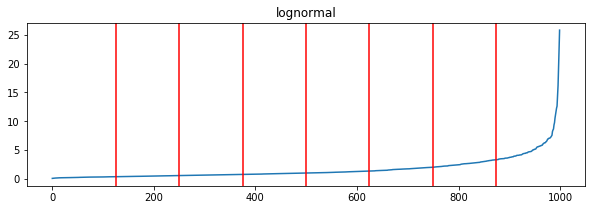

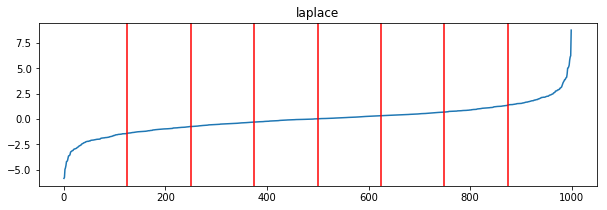

In [203]:
dichtomizer = MaxentropyDichtomizationTransformer(8)

distributions = {
    "normal": np.random.normal(size=1000),
    "poisson": np.random.poisson(size=1000),
    "uniform": np.random.uniform(size=1000),
    "lognormal": np.random.lognormal(size=1000),
    "laplace": np.random.laplace(size=1000)
}

dichtomizer.fit(distributions['normal'].reshape(-1, 1))
#dichtomizer.transform(distributions['normal'].reshape(-1, 1))
for _name, _samples in distributions.items():
    dichtomizer.fit(_samples.reshape(-1, 1))
    
    plt.figure(figsize=(10, 3))
    plt.plot(np.sort(_samples))
    plt.title(_name)
    for i in dichtomizer._splits_indices[0][:-1]:
        plt.axvline(x=i[1], color='r')

# Эксперимент на синтетике

In [226]:
X, y, coefs = make_regression(n_samples=2000, n_features=15, n_informative=4, n_targets=4, coef=True, random_state=42)
X = np.concatenate([X, y[:, :-1]], axis=1)
y = y[:, -1]#.reshape(-1, 1)

In [228]:
feature_space = []
binarizers = []
for i in range(X.shape[1]):
    feature = X[:, i].reshape(-1, 1)
    binarizer = MaxentropyDichtomizationTransformer(32).fit(feature)
    dichtomized_feature = binarizer.transform(feature)
    encoder = OneHotEncoder(sparse=False).fit(dichtomized_feature)
    
    binarizers.append({
        'binarizer': binarizer, 
        'encoder': encoder
    })
    
    feature_space.append(
        {'category': dichtomized_feature,
        'onehot': encoder.transform(dichtomized_feature)}
    )
    
y = MaxentropyDichtomizationTransformer(32).fit(y.reshape(-1, 1)).transform(y.reshape(-1, 1))

In [229]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', bagging_freq=5, bagging_fraction=.05, feature_fraction=.1),
    'lr': LogisticRegression(random_state=42, multi_class='ovr'),
    'svc': LinearSVC(multi_class='ovr'),
}

In [230]:
def score_models(models, X, y, folds = 8):
    stats = {}

    for k, model in models.items():
        stats[k] = []
        kfold = KFold(n_splits=8, shuffle=True)

        for train_ix, test_ix in kfold.split(X, y):
            X_crossval_train, X_crossval_test = X[train_ix], X[test_ix]
            y_crossval_train, y_crossval_test = y[train_ix], y[test_ix]

            model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[k].append(accuracy_score(model.predict(X_crossval_test), y_crossval_test, normalize=True))
    
    for model, model_stats in stats.items():
        print('{}, Accuracy: {}'.format(model, np.mean(model_stats)))


In [231]:
score_models(models, X, y, 8)

rf, Accuracy: 0.08349999999999999
lr, Accuracy: 0.157
svc, Accuracy: 0.049


In [232]:
np.random.seed(42)

global_stats = []
ix_subsets = []
for initial_feature in range(len(feature_space)):
    #initial_feature = 0# np.random.randint(0, len(feature_space))

    dataset_size = X.shape[0]
    # free_features is a list of observation indices
    free_features = [i for i in range(len(feature_space)) if i != initial_feature]
    # subset is a list of observations
    subset = [feature_space[initial_feature]['onehot']]
    # indices of the features in the subset
    subset_indices = [initial_feature]

    while len(subset) != len(feature_space):
        max_entropy = -1
        feature_index = -1
        new_feature = None

        local_stats = []

        for ix_feature, feature in enumerate(free_features):
            if len(subset) > 1:
                input_features = np.concatenate(subset, axis=1)
            else:
                input_features = subset[0]

            clr = copy(models['lr'])
            #train model on the given subset and new feature
            clr.fit(input_features, feature_space[feature]['category'].squeeze())
            #predict that feature with the given subset
            predicted = clr.predict(input_features)

            predicted_onehot = binarizers[feature]['encoder'].transform(predicted.reshape(-1, 1))
            pred_difference = (predicted_onehot != feature_space[feature]['onehot']).astype(np.int32) # 0110

            pred_category, pred_counts = np.unique(predicted, return_counts=True)
            real_category, real_counts = np.unique(feature_space[feature]['category'], return_counts=True)

            pred_proba = pred_counts / dataset_size
            real_proba = real_counts / dataset_size

            real_stats = dict(zip(real_category, real_proba))
            pred_stats =  dict(zip(pred_category, pred_proba))

            synchronize_counts(real_stats, pred_stats)

            ce_r_r = cross_entropy(list(real_stats.values()), list(real_stats.values()))
            ce_p_p = cross_entropy(list(pred_stats.values()), list(pred_stats.values()))
            ce_r_p = cross_entropy(list(real_stats.values()), list(pred_stats.values()))

            if max_entropy < ce_r_p:
                max_entropy = ce_r_p
                feature_index = ix_feature
                new_feature = pred_difference

            local_stats.append({'rr': ce_r_r, 'pp': ce_p_p, 'rp': ce_r_p})
        
        subset.append(new_feature)
        subset_indices.append(free_features[feature_index])
        del free_features[feature_index]

    #print('generated ordered list of variables')
    global_stats.append(local_stats)
    ix_subsets.append(subset_indices)
    print(subset_indices)
    print('score on new features:')
    score_models(models, np.hstack(subset), y, 8)
    
print('real informative variables')
print(np.unique(np.argwhere(coefs > 0)).tolist() + [15, 16, 17])

[0, 17, 16, 1, 14, 15, 4, 11, 2, 13, 5, 3, 12, 8, 9, 10, 7, 6]
score on new features:
rf, Accuracy: 0.0325
lr, Accuracy: 0.07
svc, Accuracy: 0.055999999999999994
[1, 17, 8, 12, 2, 16, 9, 10, 3, 13, 7, 6, 4, 0, 14, 5, 11, 15]
score on new features:
rf, Accuracy: 0.029500000000000002
lr, Accuracy: 0.060000000000000005
svc, Accuracy: 0.062
[2, 4, 3, 6, 16, 10, 12, 11, 8, 9, 15, 14, 1, 5, 7, 13, 0, 17]
score on new features:
rf, Accuracy: 0.0335
lr, Accuracy: 0.034
svc, Accuracy: 0.0295
[3, 15, 14, 17, 0, 7, 5, 13, 11, 9, 8, 6, 1, 4, 12, 2, 16, 10]
score on new features:
rf, Accuracy: 0.031
lr, Accuracy: 0.07700000000000001
svc, Accuracy: 0.07050000000000001
[4, 10, 1, 15, 16, 9, 14, 11, 7, 8, 6, 12, 3, 5, 17, 0, 2, 13]
score on new features:
rf, Accuracy: 0.026500000000000003
lr, Accuracy: 0.0575
svc, Accuracy: 0.056499999999999995
[5, 1, 16, 12, 8, 11, 3, 17, 6, 13, 14, 7, 9, 10, 0, 2, 4, 15]
score on new features:
rf, Accuracy: 0.031
lr, Accuracy: 0.044
svc, Accuracy: 0.039
[6, 0, 3, 17

# Попытка отранжировать переменные по значимости

## (как часто кросс-энтропия была максимальной)

In [233]:
indices_scores = {k: 0 for k in range(0, 18)}

for i in ix_subsets:
    for s, j in enumerate(i[::-1][:-1]):
        indices_scores[j] += (s + 1)

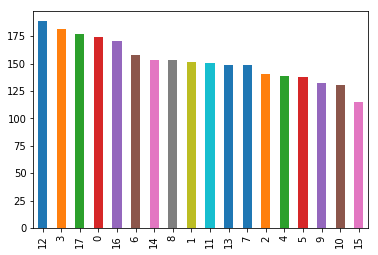

In [234]:
pd.Series(indices_scores).sort_values(ascending=False).plot(kind='bar')